### LSTMs Sentiment Analysis


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Jobfair-Project/Sentiment-Analysis-Commentwith-Foody"

/content/drive/MyDrive/Jobfair-Project/Sentiment-Analysis-Commentwith-Foody


### Introduction

今日の急成長する電子商取引業界では、ユーザーのコメントの収集と分析が重要です。これらのコメントには、コンテンツのフィルタリング、関連アイテムや場所の推奨、製品やサービスの品質評価に役立つ貴重な情報が含まれています。ただし、毎日受け取るコメントの数が多いため、ユーザーのコメントを分類することは困難で、リソースが必要です。AIとディープラーニングモデルの進歩により、高い精度でこの問題を解決することができるようになりました。具体的には、このタスクでは、ベトナムのコメントを分析して表現された感情を特定することに焦点を当てています。

![Product Review](https://techbroll.com/wp-content/uploads/2017/11/Customerfeedback.jpg)

## 問題の解決方法：LSTMネットワークによる感情分析

**Sentiment Analysis** (感情分析) の問題を解決するために、**LSTM** (Long Short-Term Memory, 長短期記憶) ネットワークを使用します。入力はテキストデータです。

必要な出力は、テキスト内に表現された感情の種類です：ポジティブ、ネガティブ、またはニュートラル（positive - negative - neutral）。この課題では、ポジティブとネガティブの2つの感情に注目します。



## **モデル**の評価方法
トレーニングされたモデルは、3000件のラベルが非表示のコメントデータセットを使用して、F1スコアを用いて評価されます。

## **解決方法**の見つけ方*
### **dataset**

私たちはFoodyウェブサイト上のレビューデータセットを使用します。このデータセットには約30,000のサンプルがあり、そのうち15,000はポジティブで、15,000はネガティブにラベル付けされています（出典：https://streetcodevn.com/blog/dataset）。

以下のコードを使用して、このデータセットをダウンロードできます.

In [4]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1eF0jg_8P0NnUiiL3HjBaJ8AC2T1sJXiK', dest_path='./course5data.zip', unzip=True)

In [5]:
!pwd

/content/drive/MyDrive/Jobfair-Project/Sentiment-Analysis-Commentwith-Foody


In [7]:
data_dir = 'course5data'
!ls {data_dir}

sample_submission.csv  test.csv  train.csv  words_list.npy  word_vectors.npy



以下のファイルが含まれています：
- **train.csv**: ラベル付きの27,000のデータサンプルを含むCSVファイルです。
- **test.csv**: 評価に使用される3,000のテストサンプルを含むファイルです。
- **sample_submission.csv**: 結果を提出する形式を示すサンプルファイルです。
- **word_list.npy**: 処理済みのベトナム語の単語リストを含むNumpyファイルです。
- **word_vectors.npy**: **word_list.npy**内の単語のベクトル表現を含むNumpyファイルです。





**ベクトル**の視点からの問題分析

もしテキストの入力形式を文字列のまま保持する場合、内積（dot product）の計算やsoftmax関数への入力、バックプロパゲーションなどの数学的な操作が非常に困難になります。

そのため、テキストの入力形式を文字列ではなく、計算を容易にするためにベクトル表現に変換することが重要です。これにより、内積やsoftmax関数などの演算や、バックプロパゲーションなどのニューラルネットワークアルゴリズムを実行することができます。

![](https://images.viblo.asia/full/b280519a-d477-4770-80e7-15e065907f14.png)

In [8]:
import os
import sys
import time
import datetime
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf

# Enable Eager Execution

tf.executing_eagerly()

import warnings
warnings.filterwarnings("ignore")

In [9]:
tf.__version__


'2.12.0'

## **トレーニングデータ**の準備

データのダウンロード
以下のコードを使用して、train.csvファイルからデータをダウンロードします。

In [10]:
pd.options.display.max_colwidth = 1000
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_df.head()

,id,text,class
0,dee6dfc5,"Đến quán 2 lần thôi , rất là thích !\r\nQuán tuy nằm trong hẻm nhưng rất dễ tìm , quán rộng_rãi thoáng mát sạch_sẽ .\r\nNhân_viên phục_vụ nhiệt_tình , siêu dễ_thương .\r\nThực_đơn phong_phú đa_dạng , giá siêu rẻ .\r\nThức_ăn nêm nếm hợp_khẩu vị , ngon_miệng .\r\nDesert ngọt vừa , không quá ngấy , rất ngon .\r\nTrà sữa , uyên_ương thơm và đúng vị mình đã từng uống ở HongKong .\r\nNói_chung điểm 10 cho chất_lượng , thích quán lắm !",1
1,800813f5,Đến quán vào tối chủ_nhật . Có band hát . Khá ổn . Tuy_nhiên không_gian tầng 1 hơi hẹp . Ngồi cả ra vỉa_hè . Đồ uống ko ngon lămz,0
2,6553e47f,Phục_vụ lâu quá mặc_dù khách rất vắng .\r\nĐợi gần 15p mới mang được ly cà_phê ra . Ông này chỉ khéo quảng_bá chứ với mình chắc không quay lại_nữa .,0
3,b45a1ff1,"Ko gian bé_tí , quán chật_chội , đông người nên phục_vụ chưa tốt . Đồ uống bình_thường ( đặc_biệt khi so với giá_cả ) và ko có gì đặc_sắc cả .",0
4,f92694b0,"Khi mình order , đặt bánh thì nhận được sự tiếp_đãi , tư_vấn và nói_chuyện rất gần_gũi , rất nhiệt_tình .\r\nBánh thì rất tuyệt , nhân béo , rau_câu không dùng phẩm . Sau_này có dịp sinh_nhật , mình sẽ order mẫu lớn .\r\nChúc các bạn làm_ăn phát_đạt !",1


In [11]:
print('number of positive:', np.sum(train_df['class']== 1))
print('number of negative:', np.sum(train_df['class']== 0))

number of positive: 13518
number of negative: 13482


データには3つの列が含まれています：`id`、`text`、`class`。具体的には：

- `id`：データのID
- `text`：前処理されたテキストデータで、単語と句読点が統合されています。
- `class`：データのラベルで、1はポジティブ、0はネガティブです。

In [12]:
print('Sample positive comment: ')
sample_positive = train_df[train_df['class'] == 1].sample(1)
print(sample_positive.loc[sample_positive.index[0], 'text'])

print('\n Sample negative comment: ')
sample_negative = train_df[train_df['class'] == 0].sample(1)
print(sample_negative.loc[sample_negative.index[0], 'text'])


Sample positive comment: 
Không_gian quán thoáng_đãng . Mình thích nhất ở đây là cách decor của quán . Tạo cảm_giác rất thân_thiện . Buổi tối có piano nhưng không hề tính phí phụ_thu . Mấy em mèo thì dễ_thương khỏi chê . Nhân_viên nhiệt_tình với khách . Mấy món ăn_ở đây ăn rất ngon . Nhất_là bánh toast , tuy mình đã ăn toast ở nhiều nơi nhưng bánh ở đây ngon hơn rất nhiều những nơi khác , bánh rất giòn và ngon . Soda được để trong bình nhìn rất dễ_thương . Soda có rất nhiều vị cho bạn lựa_chọn từ_vị trái_cây cho_đến vị bánh applepie hay blu ocean , tamarind , ... . Giá_cả cũng không phải là vấn_đề . Tuy so với những quán tự_phục_vụ đang nổi khác thì hơi cao nhưng tính thêm phí phục_vụ vô_cùng nhiệt_tình của các bạn nhân_viên thì giá_như vậy_là hoàn_toàn hợp_lí . Mọi thứ với mình đều rất ok . Sẽ quay lại quán nhiều lần nữa . Yêu qá mất rồi . < 3 < 3 ! ! !

 Sample negative comment: 
Nhân_viên khá thân_thiện , phục_vụ hơi chậm .
Thức_ăn nêm nếm được .
Giá hơi đắt so với chất_lượng .
Giữ 

In [13]:
# load data from test.csv
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
test_df.head()

,id,text
0,2017ec48,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà ăn cái nào cũng như nhau , cứ như đang ăn 1 loại vậy . Cuối cùng ngon nhất lại là cục khoai môn chiên . Mấy loại há cảo xíu mại bánh xẹp ăn ngán cực kỳ , mà làm cục to tổ bố để ép khách mua với cái giá 19k . Ko hiểu ăn được cái gì ở đây mà có người khen ngon"
1,e3f0ea32,"Ăn ở đây từ trc khi chủ nhà xây nhà mới . chất lg ko đổi còn giá có tăng từ từ 1-2k : ) )\r\nphần mìh kiu là 2 thường 2 trứng 22k - hơi no tẹo và CỰC KÌ NGONNN > <\r\nđi vạn kiếp rẽ vào hẻm có biển hoa đàm ni tự và đi chừng 50m là tới , vì hẻm 2m nên để xe bên ngoài dọc theo 2 dãy nhà , chú chủ sẽ sắp xếp xe lại nhưng mình khuyến khích các b mua về : ) ) ăn tại chỗ thì bàn ghế sạch sẽ , ly uống nước là loại dùng 1 lần - > kết điểm này ! ! !\r\nphục vụ của 2 vk ck chủ thì miễn bàn , cực kì thân thiện . dạo này có 1 cô nữa phụ bán nhưng ko dc lanh lẹ lắm .\r\n* quán chỉ bán buổi sáng tới chừng 9-10g là hết . lâu lâu thì 11g .\r\n* hành phi tự làm ngon và giòn lắm nhé ^ ^ còn bánh cuốn thì gọi tới đâu làm tới đó , ko qá lâu và bánh còn ấm ."
2,8743eae3,"Các bạn đến ăn ngay và luôn đi nhé ! !\r\nMình từ trước giờ chỉ Súp cua Súp óc heo làm tới , từ khi tới quán , mình đã biết thêm nhiều loại khác ( rong biển , hến , thập cẩm , . . mới đây còn có thêm súp còi điệp ) . Không chỉ có súp không âu nha , nhìn menu mà món nào cũng muôn ăn ... Ah , bánh Flan trà xanh cực ngon luôn , món khoái khẩu của mình ấy ... Mình không có thói quen chộp hình thức ăn trước khi ăn , nên các bạn đến ngay SÚP SÀI GÒN Q4 và cảm nhận nhé ^ ^"
3,7b554248,"Đây gần như quán ruột của mình luôn : ) ) đây đồ ăn ngon , nhân viên dễ thương , mấy anh giữ xe phía ngoài cũng dễ thương ko kém : ) ) giá cả thì hợp lý khỏi bàn luôn rồi . Đây là 3 món ruột , lần nào đến cũng phải ăn : ) ) ) hahaaa"
4,bedd1403,"Tiếc là 25 năm sống ở Tây Ninh thì đây là lần đầu tiên mình ghé .\r\nThức ăn rất Việt Nam , ngon và vị tuyệt vời , giá hợp lý .\r\nKhuyết điểm :\r\nGiờ cơm trưa quán đắc nên đợi rất lâu ,\r\nMình quên giử số điện thoại để đặt chổ và thức ăn trước , a e ai ghé thì thêm vào giúp .\r\nHơi nóng , và chắc vì quán đông quá nên phần mỷ quan có điễm trừ ,"


In [14]:
len(train_df)     #number of test samples

27000

### **単語埋め込みのダウンロード**

以下のコードを使用して、単語埋め込み（ベクトル表現）のデータをダウンロードします。


In [15]:
word_list = np.load(os.path.join(data_dir, 'words_list.npy'))
print("prunned vocabulary loaded")
words_list = word_list.tolist()
word_vectors = np.load(os.path.join(data_dir, 'word_vectors.npy'))
word_vectors = np.float32(word_vectors)
print ('Word embedding matrix loaded!')

prunned vocabulary loaded
Word embedding matrix loaded!


In [16]:
#データが正しくアップロードされたかどうかを確認する
print('Size of the vocabulary: ', len(words_list))
print('Size of the word embedding matrix: ', word_vectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


In [17]:
# 単語の単語ベクトルを取得する
np.set_printoptions(threshold=5)
for i in range(5):
  print('Index', i, 'belongs to the words', words_list[i])
  print('vector representation:', word_vectors[i], '\t size', word_vectors[i].shape)
  print()


Index 0 belongs to the words ăm
vector representation: [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228] 	 size (300,)

Index 1 belongs to the words sửng_sốt
vector representation: [-0.0535  0.0028  0.0876 ... -0.0419  0.0083 -0.0112] 	 size (300,)

Index 2 belongs to the words có_học
vector representation: [-0.0165 -0.0346  0.0616 ... -0.0876  0.0095 -0.0098] 	 size (300,)

Index 3 belongs to the words việc_làm
vector representation: [ 0.0024  0.0056  0.1076 ... -0.0454 -0.0175 -0.0269] 	 size (300,)

Index 4 belongs to the words vanila
vector representation: [ 0.0722 -0.0154  0.0271 ... -0.0013  0.033   0.054 ] 	 size (300,)



In [18]:
# vector retrival
word2idx = {w:i for i,w in enumerate(words_list)}
# print(word2idx)

word = 'dở'
word_idx = words_list.index(word)
word_vec = word_vectors[word_idx]


### **テキストの前処理**


In [19]:
import re

strip_special_chars = re.compile("[^\w0-9 ]+")

def clean_sentences(string):
  string = string.lower().replace("<br />", " ")
  return re.sub(strip_special_chars, "", string.lower())

## **キストの単語埋め込み行列への変換**

In [20]:

def get_sentence_indices(sentence, max_seq_length, _word_list):
    """
    The function is used to get indices for each word in the sentence
    Parameter
    -----------
    sentence: str
        The sentence to process.
    max_seq_length: int
        The maximum limit of words in a sentence
    _word_list: list
        A local copy of the word_list passed into the function
    """

    indices = np.zeros((max_seq_length), dtype='int32')
    words = [word.lower() for word in sentence.split()]

    unk_idx = word2idx['UNK']

    for idx, word in enumerate(words):
        if idx > max_seq_length - 1:
            break
        elif word in word2idx:
            indices[idx] = word2idx[word]
        else:
            indices[idx] = unk_idx
    return indices

# test
sentence = "Món này ăn hoài không biết chán"
sentence = clean_sentences(sentence)
sentence_indices = get_sentence_indices(sentence, max_seq_length=10, _word_list=words_list)
for i in range(len(sentence.split())):
    print(sentence.split()[i], '--->', sentence_indices[i])

print(sentence_indices)


món ---> 119
này ---> 8136
ăn ---> 4884
hoài ---> 18791
không ---> 16614
biết ---> 15951
chán ---> 3371
[ 119 8136 4884 ...    0    0    0]


In [21]:
print('Vector representation of sentence:')
print(tf.nn.embedding_lookup(word_vectors,sentence_indices))

Vector representation of sentence:
tf.Tensor(
[[-0.1823 -0.0638  0.2376 ...  0.1462 -0.1092  0.0137]
 [ 0.027  -0.0542  0.1437 ... -0.0913  0.0114  0.0132]
 [ 0.021   0.0102  0.0096 ...  0.411  -0.2519  0.0151]
 ...
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]], shape=(10, 300), dtype=float32)


### **トレーニングデータセット調査**

In [22]:
num_words = [len(clean_sentences(x).split()) for x in list(train_df['text'])]
print('The total number of samples is', len(train_df))
print('The total number of words in the files is', sum(num_words))
print('The average number of words in the files is', sum(num_words)/len(num_words))

The total number of samples is 27000
The total number of words in the files is 2252760
The average number of words in the files is 83.43555555555555


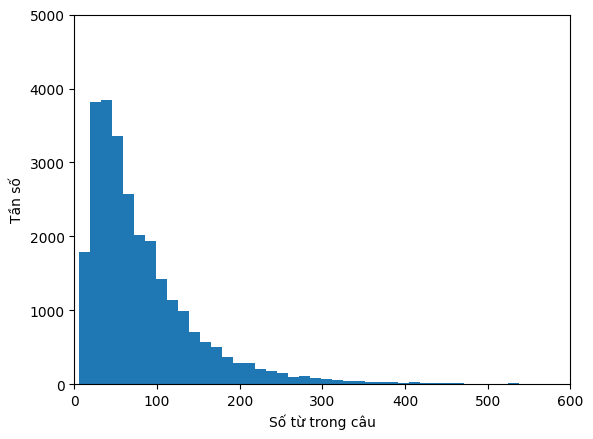

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(num_words, 100)
plt.xlabel('Số từ trong câu')
plt.ylabel('Tần số')
plt.axis([0, 600, 0, 5000])
plt.show()

In [24]:
MAX_SEQ_LENGTH = 200

### テキストデータを行列に変換する

In [25]:
def text2ids(df, max_length, _word_list):

    ids = np.zeros((len(df), max_length), dtype='int32')
    for idx, text in enumerate(tqdm(df['text'])):
        ids[idx,:] = get_sentence_indices(clean_sentences(text), max_length, _word_list)
    return ids

print("Converting train_df...")
train_ids = text2ids(train_df, MAX_SEQ_LENGTH, words_list)
np.save('train_ids.npy', train_ids)


Converting train_df...


100%|██████████| 27000/27000 [00:02<00:00, 11019.06it/s]


In [26]:
train_ids = np.load('train_ids.npy')

In [27]:
print('Word indices of the first review: ')
print(train_ids[0])

Word indices of the first review: 
[10774 11975  4826 ...     0     0     0]



## **データのトレーニング、検証、テストセットへの分割**
train:validation:test = 0.8 :0.1 :0.1


In [28]:
train_x, test_validation_x, train_y, test_validation_y  = train_test_split(train_ids, train_df['class'], test_size=0.2, random_state=2019)
validation_x, test_x, validation_y, test_y = train_test_split(test_validation_x, test_validation_y, test_size=0.5, random_state=2018)

In [29]:
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)) # train_x, train_y
train_dataset = train_dataset.batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_x, validation_y)) # validation_x, validation_y
validation_dataset = validation_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)) # test_x, test_y
test_dataset = test_dataset.batch(BATCH_SIZE)


for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print('FIRST BATCH:')
        print('X =',x)
        print('y =',y)
print("Total: ", idx)

FIRST BATCH:
X = tf.Tensor(
[[12844  5596  4884 ...     0     0     0]
 [10774 16521 13952 ...     0     0     0]
 [ 7446 10698 10774 ...     0     0     0]
 ...
 [ 4884 16995  4601 ...     0     0     0]
 [ 3913 15085 14017 ...     0     0     0]
 [ 4788 14598   310 ...     0     0     0]], shape=(256, 200), dtype=int32)
y = tf.Tensor([0 0 1 ... 0 1 1], shape=(256,), dtype=int64)
Total:  84


In [30]:
for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print('EMBEDDING OF FIRST BATCH:')
        print(tf.nn.embedding_lookup(word_vectors, x))

EMBEDDING OF FIRST BATCH:
tf.Tensor(
[[[ 2.920e-02 -2.410e-02  7.960e-02 ...  8.000e-04 -2.180e-02 -7.700e-03]
  [-7.600e-03 -4.540e-02  4.880e-02 ... -1.456e-01 -1.232e-01 -2.590e-02]
  [ 2.100e-02  1.020e-02  9.600e-03 ...  4.110e-01 -2.519e-01  1.510e-02]
  ...
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]]

 [[-5.800e-03 -6.460e-02  1.976e-01 ... -1.739e-01  1.770e-02 -2.780e-02]
  [-6.140e-02  4.890e-02  8.530e-02 ... -3.620e-02  4.590e-02 -6.180e-02]
  [ 2.150e-02 -4.110e-02  2.015e-01 ... -9.910e-02 -4.840e-02  6.100e-03]
  ...
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]]

 [[ 4.510e-02 -2.430e-02  2.318e-01 ...  7.880e-02 -5.000e-

## LSTM Layer

In [42]:
if tf.test.is_gpu_available():
    print('Using GPU LSTM')
    lstm_layer = tf.keras.layers.LSTM
else:
    print('Using CPU LSTM')
    lstm_layer = tf.keras.layers.LSTM


Using GPU LSTM


In [51]:
class sentimentAnalysisModel(tf.keras.Model):
    """
    word2vec: numpy.array
        Word vectors.
    lstm_layers: list
        List of LSTM layers. The last LSTM layer returns the output of the last LSTM layer.
    dropout_layers: list
        List of dropout layers.
    dense_layer: Keras Dense Layer
        The final dense layer that takes input from LSTM and outputs the number of classes using softmax activation.
    """
    def __init__(self, word2vec, lstm_units, n_layers, num_classes, dropout_rate=0.25):
        """
        initialize model
        Paramters
        ---------
        word2vec: numpy.array
        lstm_units: int
        n_layers: int
        num_classes: int
        dropout_rate: float
        """

        super().__init__(name='sentiment_analysis')

        #initialize model properties
        self.word2vec = word2vec

        self.lstm_layers = []   #list to hold LSTM layers
        self.dropout_layers = [] #list to hold dropout layers

        for i in range(n_layers):
            new_layer = lstm_layer(units=lstm_units, name="lstm_" +str(i), return_sequences = (i< n_layers -1))
            self.lstm_layers.append(new_layer)
            self.dropout_layers.append(tf.keras.layers.Dropout(rate=dropout_rate, name="dropout_"+str(i)))

        self.dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name="dense_0")

    def call(self, inputs):
        #perform forward pass of the input throught the network
        inputs = tf.cast(inputs, tf.int32)
        #input is currently in indices, need to convert to vectors
        inputs = tf.nn.embedding_lookup(self.word2vec, inputs)

        for i in range(len(self.lstm_layers)):
            inputs = self.lstm_layers[i](inputs)
            inputs = self.dropout_layers[i](inputs)
        out = self.dense_layer(inputs)
        return out


In [44]:
# Hyperparameters
LSTM_UNITS = 128
N_LAYERS = 2
NUM_CLASSES = 2


In [52]:
model = sentimentAnalysisModel(word_vectors, LSTM_UNITS, N_LAYERS, NUM_CLASSES)

In [46]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
EPOCHS = 50

global_step = tf.Variable(0, trainable=False, dtype=tf.int64, name='global_step')
checkpoint_dir = './model'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{score}")


In [47]:
from fastprogress import master_bar, progress_bar

## Epoch Training

In [91]:
def epoch_training(model, dataset, global_step, mb, num_step):
    """
    Huấn luyện mô hình qua 1 epoch

    Parameters
    ----------
    model: tf.keras.Model
        model cần huấn luyện
    dataset: tf.Dataset
        dataset dùng để huấn luyện
    global_step: global step
    mb: fastprogress.master_bar
        thanh biểu diễn tiến độ
    num_step: int
        số bước lặp trong mỗi epoch
    Returns
    -------
    """
    train_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, target = next(dataset_iter)

        with tf.GradientTape() as tape:
            predictions = model(inp)
            loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            loss = loss_object(target, predictions)
            train_losses.append(loss)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step = global_step)
        mb.child.comment = 'Train loss {:.4f}'.format(loss)


    return tf.reduce_mean(train_losses)

### Epoch Evaluation

In [94]:
def epoch_evaluation(model, dataset, mb, num_step):
    """
    model: tf.keras.Model
    dataset: tf.Dataset
    mb: fastprogress.master_bar
    num_step: int
    --------------------
    return
        Average Loss Value
        F1-score
    """
    val_losses = []   # loss of batch
    val_gt = []       # value of groundtruth
    val_pred = [] # value predict of model in validation
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent= mb):
       inp, target = next(dataset_iter)
       val_gt.extend(target.numpy().astype(np.int32).tolist())
       predictions = model(inp)

       loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
       loss = loss_object(target, predictions)
       val_losses.append(loss)
       val_pred.extend(tf.argmax(predictions,1).numpy().astype(np.int32).tolist())

       mb.child.comment = 'validation loss {:.4f}'.format(loss)


    return sum(val_losses)/len(val_losses), f1_score(val_gt, val_pred)

### トレーニングプロセスの確立

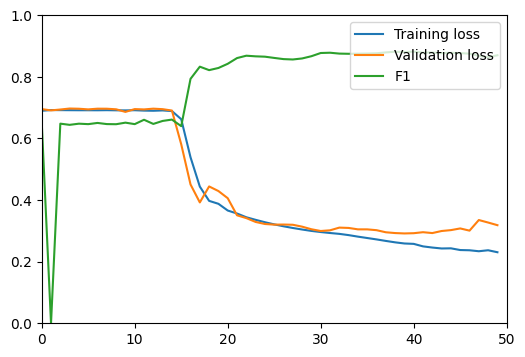

In [96]:
best_score = 0
mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'F1']
training_losses = []
validation_losses = []
f1_scores = []
x = []

train_step = math.ceil(len(train_x)*1.0/BATCH_SIZE)
val_step = math.ceil(len(validation_x)*1.0/BATCH_SIZE)
for epoch in mb:

    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    x.append(epoch)


    #training with epoch_training()
    training_loss = epoch_training(model, train_dataset, global_step, mb, num_step=train_step)

    mb.write('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    training_losses.append(training_loss)


    # evaluation with epoch_evaluation()
    valid_loss, valid_score = epoch_evaluation(model, validation_dataset, mb, num_step=val_step)

    mb.write('Finish validate epoch {} with loss {:.4f}, F1-score {:.4f}'.format(epoch,valid_loss, valid_score))
    validation_losses.append(valid_loss)
    f1_scores.append(valid_score)

    # update plot
    global_step.assign_add(1)
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, f1_scores]], [0,EPOCHS], [0,1])

    # Update score và model bestest
    if best_score < valid_score:
        mb.write(">>> Improved F1-score from {:.4f} to {:.4f}".format(best_score, valid_score))
        # Update best_score
        best_score = valid_score
        # Save model
        model.save_weights(checkpoint_prefix.format(score=valid_score))



### **ラベル付けされたテスト セットでモデルを評価する**

F1スケールを使用してモデルの精度を評価します。

In [97]:
test_loss, test_score = epoch_evaluation(model, test_dataset, mb, math.ceil(len(test_x) *1.0/BATCH_SIZE))

In [98]:
print("F1-score on test set:", test_score)

F1-score on test set: 0.8672443674176777


## **3000以上のラベルレスコメントテンプレートを予測**

In [99]:
test_df.head(10)

,id,text
0,2017ec48,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà ăn cái nào cũng như nhau , cứ như đang ăn 1 loại vậy . Cuối cùng ngon nhất lại là cục khoai môn chiên . Mấy loại há cảo xíu mại bánh xẹp ăn ngán cực kỳ , mà làm cục to tổ bố để ép khách mua với cái giá 19k . Ko hiểu ăn được cái gì ở đây mà có người khen ngon"
1,e3f0ea32,"Ăn ở đây từ trc khi chủ nhà xây nhà mới . chất lg ko đổi còn giá có tăng từ từ 1-2k : ) )\r\nphần mìh kiu là 2 thường 2 trứng 22k - hơi no tẹo và CỰC KÌ NGONNN > <\r\nđi vạn kiếp rẽ vào hẻm có biển hoa đàm ni tự và đi chừng 50m là tới , vì hẻm 2m nên để xe bên ngoài dọc theo 2 dãy nhà , chú chủ sẽ sắp xếp xe lại nhưng mình khuyến khích các b mua về : ) ) ăn tại chỗ thì bàn ghế sạch sẽ , ly uống nước là loại dùng 1 lần - > kết điểm này ! ! !\r\nphục vụ của 2 vk ck chủ thì miễn bàn , cực kì thân thiện . dạo này có 1 cô nữa phụ bán nhưng ko dc lanh lẹ lắm .\r\n* quán chỉ bán buổi sáng tới chừng 9-10g là hết . lâu lâu thì 11g .\r\n* hành phi tự làm ngon và giòn lắm nhé ^ ^ còn bánh cuốn thì gọi tới đâu làm tới đó , ko qá lâu và bánh còn ấm ."
2,8743eae3,"Các bạn đến ăn ngay và luôn đi nhé ! !\r\nMình từ trước giờ chỉ Súp cua Súp óc heo làm tới , từ khi tới quán , mình đã biết thêm nhiều loại khác ( rong biển , hến , thập cẩm , . . mới đây còn có thêm súp còi điệp ) . Không chỉ có súp không âu nha , nhìn menu mà món nào cũng muôn ăn ... Ah , bánh Flan trà xanh cực ngon luôn , món khoái khẩu của mình ấy ... Mình không có thói quen chộp hình thức ăn trước khi ăn , nên các bạn đến ngay SÚP SÀI GÒN Q4 và cảm nhận nhé ^ ^"
3,7b554248,"Đây gần như quán ruột của mình luôn : ) ) đây đồ ăn ngon , nhân viên dễ thương , mấy anh giữ xe phía ngoài cũng dễ thương ko kém : ) ) giá cả thì hợp lý khỏi bàn luôn rồi . Đây là 3 món ruột , lần nào đến cũng phải ăn : ) ) ) hahaaa"
4,bedd1403,"Tiếc là 25 năm sống ở Tây Ninh thì đây là lần đầu tiên mình ghé .\r\nThức ăn rất Việt Nam , ngon và vị tuyệt vời , giá hợp lý .\r\nKhuyết điểm :\r\nGiờ cơm trưa quán đắc nên đợi rất lâu ,\r\nMình quên giử số điện thoại để đặt chổ và thức ăn trước , a e ai ghé thì thêm vào giúp .\r\nHơi nóng , và chắc vì quán đông quá nên phần mỷ quan có điễm trừ ,"
5,8bbfd5a7,"Vâ ̃ n la ̀ Ze ́ , Ze ́ luôn nhâ ́ t 👍\r\nCuô ́ i tuâ ̀ n no nê vơ ́ i my ̀ ga ̀ phô mai , sushi , ga ̀ ra ́ n thanh cua , soda va ̀ xoa ̀ i lă ́ c\r\nPha ̉ i no ́ i la ̀ sau ca ́ i mo ́ n ba ̣ ch tuô ̣ c xa ̀ o cay thi ̀ my ̀ ga ̀ phô mai la ̀ ca ́ i mo ́ n gây nghiê ̣ n nhâ ́ t 😍 my ̀ mê ̀ m dai co ́ vi ̣ cay cay , cu ̀ ng vơ ́ i ga ̀ viên gio ̀ n gio ̀ n 👍 yêu ca ́ i mo ́ n na ̀ y\r\nXoa ̀ i lă ́ c , đâu đâu cu ̃ ng xoa ̀ i lă ́ c , ma ̀ bư ̃ a nay mơ ́ i ăn xoa ̀ i lă ́ c cu ̉ a ze ́ , hi ̀ nh như la ̀ chung công thư ́ c hay sao nên thâ ́ y ăn chô ̃ na ̀ o cu ̃ ng giô ́ ng nhau , xoa ̀ i ngon , vi ̣ vư ̀ a ăn , ko qua ́ cay hay qua ́ mă ̣ n , nhưng co ́ miê ́ ng gio ̀ n miê ́ ng thi ̀ mê ̀ m 😢 mi ̀ nh la ̣ i thi ́ ch gio ̀ n hơn , nhưng to ́ m la ̣ i la ̀ vâ ̃ n ngon\r\nChu ̉ nhâ ̣ t , ma ̀ không pha ̉ i riêng chu ̉ nhâ ̣ t , buô ̉ i tô ́ i la ̀ ze ́ đông ơi la ̀ đông , nhưng ma ̀ phu ̣ c vu ̣ vâ ̃ n nhanh nhe ̣ n , nhiê ̣ t ti ̀ nh , thi ́ ch dê ̃ sơ ̣\r\nTô ́ i nay chă ́ c ng..."
6,1b85aa7f,"Nhà hàng đẹp , không gian rộng , có phòng riêng .\r\nSo với mặt bằng và vị trị thì giá cả như vậy là hợp lí , nhưng giá thức uống thì hơi cao .\r\nNhóm 7 người order 1combo dành cho 2 người rồi gọi thêm 1 phan kim chi , linh tinh cac rau củ nướng , 1 phan bò mỹ , 1ga lá quế phô mai ( ngon ) , sashimi cá hồi , 1 sụn gà chien gion ( lượng hơi it , giá hơi cao , ngon nhưng hơi lạt 1 chút ) , 1 cơm trộn ( ko co j dac biet , ko ngon lam ) , 1 cái lẩu miso , nuoc uong . Phải nói là ăn ngập mặt thịt thà luôn , cả đám ngán thịt lun , no muon lăn về .\r\nPhải công nhận là cái combo đó wa chất lượng và đáng đồng tien lam nha , nhìn hình tưởng ít , ai dè lên món thay qua troi , neu 2 ng mà ăn 1combo cho 2ng chac no căng bụng lun .\r\nNhà hàng có chuong trinh 1 nguoi check in & like page = tặng

### **「予測」関数を構築する**


In [100]:
model.summary()

Model: "sentiment_analysis"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_0 (LSTM)               multiple                  219648    
                                                                 
 lstm_1 (LSTM)               multiple                  131584    
                                                                 
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_0 (Dense)             multiple                  258       
                                                                 
Total params: 351,490
Trainable params: 351,490
Non-trainable params: 0
_________________________________________________________________


In [101]:
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 88.6 MB/s eta 0:00:00


In [104]:
from pyvi import ViTokenizer
from keras.utils import pad_sequences
import string

def clean_document(doc):
    doc = ViTokenizer.tokenize(doc) #Pyvi Vitokenizer library
    doc = doc.lower() #Lower
    tokens = doc.split() #Split in_to words
    table = str.maketrans('', '', string.punctuation.replace("_", "")) #Remove all punctuation
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word]
    return tokens

In [105]:
try:
    from underthesea import word_tokenize
except:
    !pip install underthesea
    from underthesea import word_tokenize


def predict(sentence, model, _word_list=words_list, _max_seq_length=MAX_SEQ_LENGTH):
    """
    sentiment predicts

    Parameters
    ----------
    sentence: str
    model: model keras
    _word_list: numpy.array
    _max_seq_length: int
    Returns
    -------
    int
        0 :negative, 1 :positive
    """

    # Tokenize/Separate words in sentences
    # Use the word_tokenize function just imported above
    tokenized_sent = clean_document(sentence)
    tokenized_sent = ' '.join(tokenized_sent)


    # Return the tokenized sentence to the appropriate input_data form to pass into the model
    input_data = get_sentence_indices(clean_sentences(tokenized_sent), _max_seq_length, _word_list)
    input_data = input_data.reshape(-1, _max_seq_length)

    # Pass input_data through the model to get the probability of labels
    predictions = model(input_data)
    predictions = tf.argmax(predictions,1).numpy().astype(np.int32)

    return predictions[0]



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 54.3 MB/s eta 0:00:00


In [108]:
checkpoint_dir = './model'
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [111]:
model.save_weights("model_saved/model.h5")

In [113]:
print("Test 1:",predict("món này dở ", model))
print("Test 2:",predict("đồ ăn rất ngon", model))


Test 1: 0
Test 2: 1


In [114]:
submission = pd.read_csv(data_dir+"/sample_submission.csv", index_col=0)
submission.head()

,class
id,
2017ec48,0
e3f0ea32,0
8743eae3,0
7b554248,0
bedd1403,0


In [115]:
for _, row in tqdm(test_df.iterrows()):
    submission.loc[row.id] = predict(row.text, model)


3000it [01:38, 30.38it/s]


In [116]:
submission.to_csv('submission.csv')